## Notes
--- 

Author: **Andy Tzanidakis** (atzanida@uw.edu)

This notebook is dedicated to investigating the LSP technique on Eclipsing Binaries (EB) in the PLastiCC light curves. We search for an optimal configuration to best recover the period of EB's & and minimize failure rate.

In [601]:
import numpy as np
from astropy.io import ascii
import os 
from tqdm import tqdm
from astropy.time import Time
import pandas as pd
import warnings
import time
import random
from gatspy import periodic, datasets
import matplotlib.pyplot as plt
from astropy.table import Table
from gatspy import datasets, periodic
import gatspy

import scipy.stats as sci_stat
import sys

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 250
rcParams['font.size'] = 20

global data_path
data_path = '../data/plasticc/data/'

# Caution, be careful when ignoring warnings!
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [602]:
def generate_toi_table(data, meta_info, meta_theta_EB, meta_theta_RRL):
    """
    Generate table that contains the light curve ID and transient type. 

    Input
    -----
    data: Head data table that contains photometry
    meta_info: Table that contains the meta-data (i.e classification name)
    meta_theta_<TYPE>: Table that contains metadata information (i.e Period)
    
    """
    id_av_rrl, id_av_eb = [], []

    for uid in tqdm(np.unique(data['object_id'])):
        ww = np.where(meta_theta_EB['object_id'] == uid)
        if np.shape(ww)[-1]==1:
            id_av_eb.append(uid)

    for uid in tqdm(np.unique(data['object_id'])):
        ww = np.where(meta_theta_RRL['object_id'] == uid)
        if np.shape(ww)[-1]==1:
            id_av_rrl.append(uid)

    id_av_rrl, id_av_eb = np.array(id_av_rrl), np.array(id_av_eb)

    _id1 = np.array(['rrl' for _ in range(len(id_av_rrl))])
    _id2 = np.array(['eb' for _ in range(len(id_av_eb))])

    # All ID's and & ID tags
    all_id = np.concatenate([id_av_rrl, id_av_eb])
    _id_all = np.concatenate([_id1, _id2])

    # Final TOI table
    toi_table = Table([all_id, _id_all], names=('obj_id', 'type'))

    return toi_table

In [603]:
# Read ALL PlastiCC data & meta
data = pd.read_csv(data_path + "plasticc_train_lightcurves.csv.gz",
                  compression='gzip',
                  error_bad_lines=False)

meta_info = ascii.read(data_path + "plasticc_train_metadata.csv") # ascii meta since it's smaller

# Metadata for EBs and RRL
meta_theta_EB = ascii.read(data_path + 'plasticc_modelpar/' + 'plasticc_modelpar_016_EB.csv')
meta_theta_RRL = ascii.read(data_path + 'plasticc_modelpar/' + 'plasticc_modelpar_092_RRL.csv')

# Fetch all toi's
toi_table = generate_toi_table(data, meta_info, meta_theta_EB, meta_theta_RRL)

100%|██████████| 7848/7848 [00:00<00:00, 14103.85it/s]


In [380]:
# Helper functions
def generate_lc(obj_id, band='all', data_table=data, det=1, time_cut=365):
    """Unpack and return PlastiCC data in numpy array format.
    
    Parameters:
    ------
    obj_id: Object ID
    band: Photometric bandpass filter. 'all' includes ugrizy, or 'ugrizy'
    data_table: Pandas data table containing the light curves
    det: Detection from the image subtraction algorithm. ==1 detection, ==0 not detection (i.e upper limit) or 'all': uses both 0 & 1
    """
    
    if det==0 or det==1:
        data_table_mod = data_table[data_table['detected_bool']==det]
    elif det=='all':
        data_table_mod = data_table # select both 
        
    # Select light curve based on the ID 
    lc = data_table_mod[data_table_mod['object_id']==obj_id]
    
    lsst_bands = list('ugrizy') # lsst photomeric bands
    
    lc_array = lc.to_numpy()

    # Capture empty light curve
    assert len(lc_array[:,1])>0, ("Sorry, it seems like your obj_id query was wrong!")

    mjd, flux, flux_err = lc_array[:,1], lc_array[:,3], lc_array[:,4]
    flt = lc_array[:,2].astype(int).astype(str)    
    dt = mjd-mjd[0] # baseline time
    dt_sel = dt<=time_cut 
    mjd, flux, flux_err, flt = mjd[dt_sel], flux[dt_sel], flux_err[dt_sel], flt[dt_sel] # select
    
    for j in range(6):
        flt[flt==str(j)] = lsst_bands[j]
    
    if band=='all':
        return mjd, flux, flux_err, flt
    else:
        return mjd[flt==band], flux[flt==band], flux_err[flt==band], flt[flt==band]
     

def fetch_type(lid, table=toi_table):
    """Fetch the classification type of transient given light curve table and original head TOI table."""
    return table[table['obj_id']==lid]


def fetch_meta_info(lc_id, lc_type):
    """Fetch metadata for transient type.
    
    Input
    -----
    lc_id: Light curve ID 
    lc_type: classification type (i.e rrl, eb)

    Output
    ------
    meta_<type>_table: Table that contains metadata (i.e period and other physical properties)
    """
    if lc_type=='rrl':
        # crossmatch to approprirate table
        xm_ = np.where(meta_theta_RRL['object_id']==lc_id)
        return meta_theta_RRL[xm_]
    elif lc_type=='eb':
        # crossmatch to approprirate table
        xm_ = np.where(meta_theta_EB['object_id']==lc_id)
        return meta_theta_EB[xm_]

# Write a function that will generate N random from each class (equal)
def draw_rand_trans(table, N=10, class_type='rrl'):
    """Given N this function will draw an equal number of trnasinets.
       Note: It will not draw the same transiennt
    """
    # isolate each unique class
    req_tab = table[table['type']==class_type]  
    
    # Random number generator w/o repeat
    rng = np.random.default_rng()
    rn = rng.choice(len(req_tab), size=N, replace=False)
    
    return req_tab[rn]  

In [456]:
rand_eb[0]

obj_id,type
int64,str3
17596103,eb


In [597]:
cid, ndets = [], []

# Draw a random EB
rand_eb = draw_rand_trans(toi_table, N=924, class_type='eb')

for i in tqdm(range(len(rand_eb))):
    lc = generate_lc(rand_eb['obj_id'][i], band='all', det='all', time_cut=365)

    cid.append(rand_eb['obj_id'][i])
    ndets.append(len(lc[0]))
    
cid = np.array(cid)
ndets = np.array(ndets)

# sort them 
ndet_sort = np.argsort(ndets)
cid, ndets = cid[ndet_sort], ndets[ndet_sort]

100%|██████████| 924/924 [00:00<00:00, 1056.30it/s]


Text(0, 0.5, 'Log (N)')

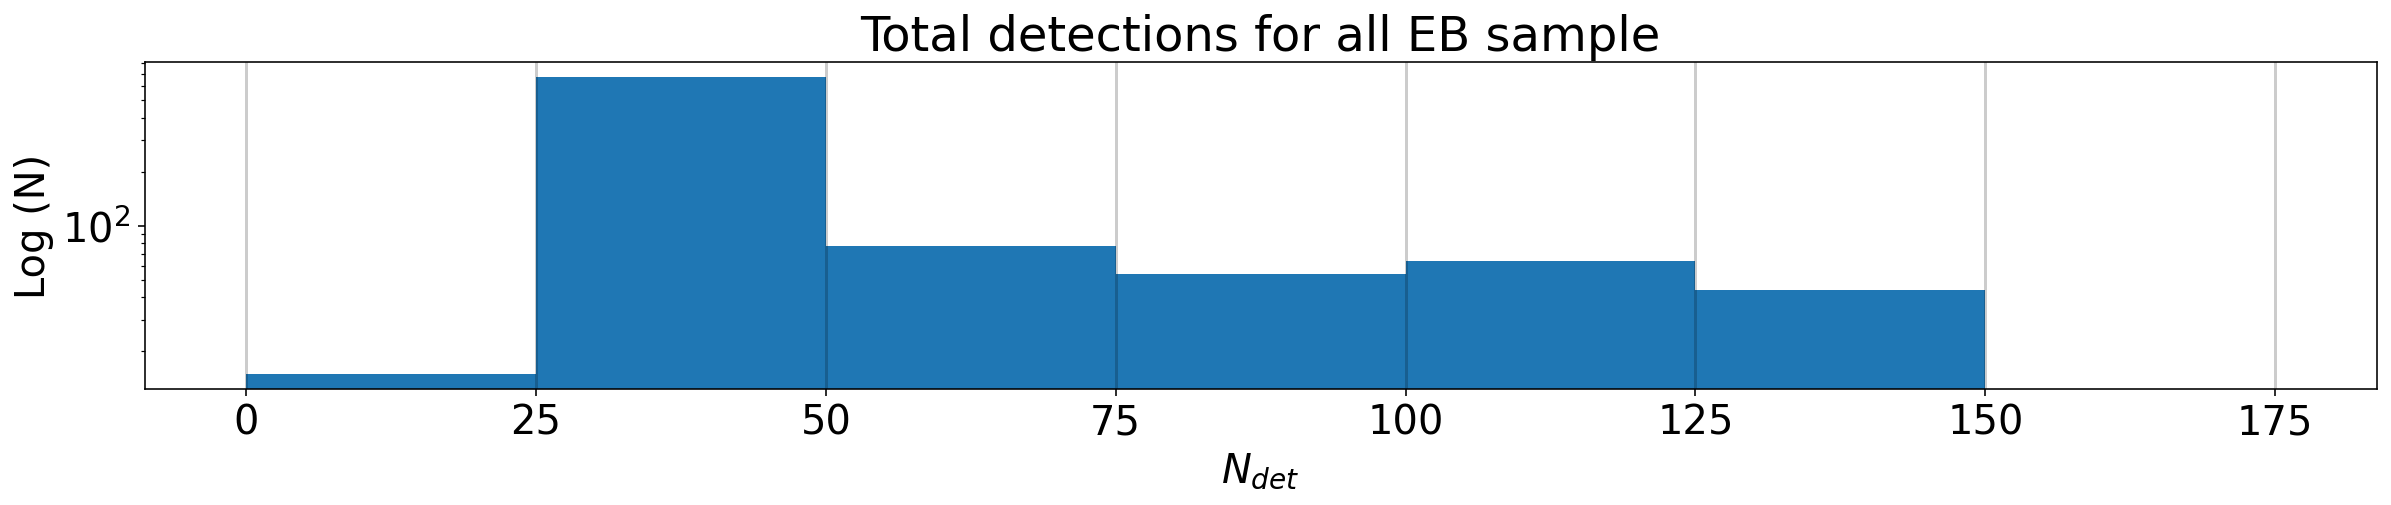

In [598]:
plt.figure(figsize=(20,3))
_ = plt.hist(ndets, bins=np.arange(0, 200, step=25))
for j in np.arange(0, 200, step=25):
    plt.axvline(j, color='k', alpha=0.2)
    
_ = plt.xticks(np.arange(0, 200, step=25))
plt.yscale('log')
plt.title("Total detections for all EB sample")
plt.xlabel("$N_{det}$")
plt.ylabel("Log (N)")

In [600]:
# Object id for each bin

print (f"Index for 0-25 det candidates: {cid[(ndets>0) & (ndets<25)][-1]}")
print (f"Index for 25-50 det candidates: {cid[(ndets>25) & (ndets<50)][-1]}")
print (f"Index for 50-75 det candidates: {cid[(ndets>50) & (ndets<75)][-1]}")
print (f"Index for 75-100 det candidates: {cid[(ndets>75) & (ndets<100)][-1]}")
print (f"Index for 100-125 det candidates: {cid[(ndets>100) & (ndets<125)][-1]}")

Index for 0-25 det candidates: 36405978
Index for 25-50 det candidates: 1415987
Index for 50-75 det candidates: 66586389
Index for 75-100 det candidates: 139016
Index for 100-125 det candidates: 187120


In [614]:
# Load all light curve candidates
t1, f1, ferr1, flt1 = generate_lc(36405978, band='all', det='all', time_cut=365)
t2, f2, ferr2, flt2 = generate_lc(1415987, band='all', det='all', time_cut=365)
t3, f3, ferr3, flt3 = generate_lc(66586389, band='all', det='all', time_cut=365)
t4, f4, ferr4, flt4 = generate_lc(139016, band='all', det='all', time_cut=365)
t5, f5, ferr5, flt5 = generate_lc(187120, band='all', det='all', time_cut=365)

# Load all periods
per1 = fetch_meta_info(36405978, 'eb')['PERIOD'][0]
per2 = fetch_meta_info(1415987, 'eb')['PERIOD'][0]
per3 = fetch_meta_info(66586389, 'eb')['PERIOD'][0]
per4 = fetch_meta_info(139016, 'eb')['PERIOD'][0]
per5 = fetch_meta_info(187120, 'eb')['PERIOD'][0]


In [679]:
def percent_error(true, obs):
    return abs(true-obs)/true

In [814]:
for i in range(1,7):
    print (3*i)

3
6
9
12
15
18


In [822]:
# Configuration modes

pmin = 0.1
pmax = 100

rt1, rt2, rt3, rt4, rt5 = [], [], [], [], [] # runtime
e_rt1, e_rt2, e_rt3, e_rt4, e_rt5 = [], [], [], [], [] # error 
pe_1, pe_2, pe_3, pe_4, pe_5 = [], [], [], [], [] # percent error from truth

for i in tqdm(range(1, 7)):
    model = periodic.LombScargleMultiband(fit_period=True,
                                          Nterms_base=3*i, Nterms_band=2, optimizer_kwds={"quiet": True})
    model.optimizer.set(period_range=(pmin, pmax))
    
    # Ugly way... sorry!
    
    # MODEL 1 
    rt = []
    for _ in tqdm(range(5)):
        t0 = time.time()
        m1_fit = model.fit(t1, f1, dy=ferr1, filts=flt1)
        rt.append(time.time()-t0)
        
    rt1.append(np.mean(rt))
    e_rt1.append(np.std(rt))
    pe_1.append(percent_error(per1, m1_fit.best_period))
    
    # MODEL 2 
    rt = []
    for _ in tqdm(range(5)):
        t0 = time.time()
        m2_fit = model.fit(t2, f2, dy=ferr2, filts=flt2)
        rt.append(time.time()-t0)
        
    rt2.append(np.mean(rt))
    e_rt2.append(np.std(rt))
    pe_2.append(percent_error(per2, m2_fit.best_period))
    
    
    # MODEL 3
    rt = []
    for _ in tqdm(range(5)):
        t0 = time.time()
        m3_fit = model.fit(t3, f3, dy=ferr3, filts=flt3)
        rt.append(time.time()-t0)
        
    rt3.append(np.mean(rt))
    e_rt3.append(np.std(rt))
    pe_3.append(percent_error(per3, m3_fit.best_period))
    
    
    # MODEL 4
    rt = []
    for _ in tqdm(range(5)):
        t0 = time.time()
        m4_fit = model.fit(t4, f4, dy=ferr4, filts=flt4)
        rt.append(time.time()-t0)
        
    rt4.append(np.mean(rt))
    e_rt4.append(np.std(rt))
    pe_4.append(percent_error(per4, m4_fit.best_period))
    
    
    # MODEL 5
    rt = []
    for _ in tqdm(range(5)):
        t0 = time.time()
        m5_fit = model.fit(t5, f5, dy=ferr5, filts=flt5)
        rt.append(time.time()-t0)
        
    rt5.append(np.mean(rt))
    e_rt5.append(np.std(rt))
    pe_5.append(percent_error(per5, m5_fit.best_period))
    

100%|██████████| 5/5 [00:29<00:00,  5.89s/it]

100%|██████████| 5/5 [00:30<00:00,  6.04s/it]

100%|██████████| 5/5 [00:32<00:00,  6.49s/it]

100%|██████████| 5/5 [00:12<00:00,  2.45s/it]

100%|██████████| 5/5 [00:33<00:00,  6.62s/it]

100%|██████████| 5/5 [00:34<00:00,  6.97s/it]

100%|██████████| 5/5 [00:36<00:00,  7.32s/it]

100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

100%|██████████| 5/5 [00:36<00:00,  7.24s/it]

100%|██████████| 5/5 [00:38<00:00,  7.63s/it]

100%|██████████| 5/5 [00:41<00:00,  8.37s/it]

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

100%|██████████| 5/5 [00:40<00:00,  8.07s/it]

100%|██████████| 5/5 [00:43<00:00,  8.67s/it]

100%|██████████| 5/5 [00:46<00:00,  9.27s/it]

100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

100%|██████████| 5/5 [00:53<00:00, 10.73s/it]

100%|██████████| 5/5 [00:48<00:00,  9.70s/it]

100%|██████████| 5/5 [00:52<00:00, 10.56s/it]

100%|██████████| 5/5 [00:20<00:00,  4.11s/it]

100%|██████████| 5/5 [00:49<00:00,  9.80s/it]

100%|████████

100%|██████████| 5/5 [00:55<00:00, 11.16s/it]

100%|██████████| 5/5 [00:20<00:00,  4.17s/it]

100%|██████████| 6/6 [16:07<00:00, 161.28s/it]


In [ ]:
#rt1, rt2, rt3, rt4, rt5 = [], [], [], [], [] # runtime
#e_rt1, e_rt2, e_rt3, e_rt4, e_rt5 = [], [], [], [], [] # error 
#pe_1, pe_2, pe_3, pe_4, pe_5 = [], [], [], [], [] # percent error from truth

In [813]:
pe_1, pe_2, pe_3, pe_4, pe_5

([0.49999969413861145,
  3.9949922943970497e-05,
  2.0001049906820136,
  2.0002647735271872,
  0.3130373317949579,
  0.7387353862930333],
 [0.5000041959833617,
  3.6563380452870266e-05,
  0.8492053139907346,
  0.8558134917914705,
  0.9287621084741444,
  0.7188152823660322],
 [0.500458111035268,
  0.0006803156922673967,
  0.9339009053057691,
  0.9796174798753182,
  0.9542837422721199,
  0.9807485032230283],
 [42.117226230183164,
  1.6858481154026417,
  0.5000625095769435,
  2.333861681017354,
  6.03576158227086,
  0.7493441133883496],
 [0.5000234905259663,
  0.5000515829683302,
  0.5001545615869505,
  0.00020868749347091966,
  6.995351835570205,
  2.9983557065274935])

In [823]:
nds = [25, 50, 75, 100, 125]

In [824]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

Text(0.5, 1.0, 'Configuration 5')

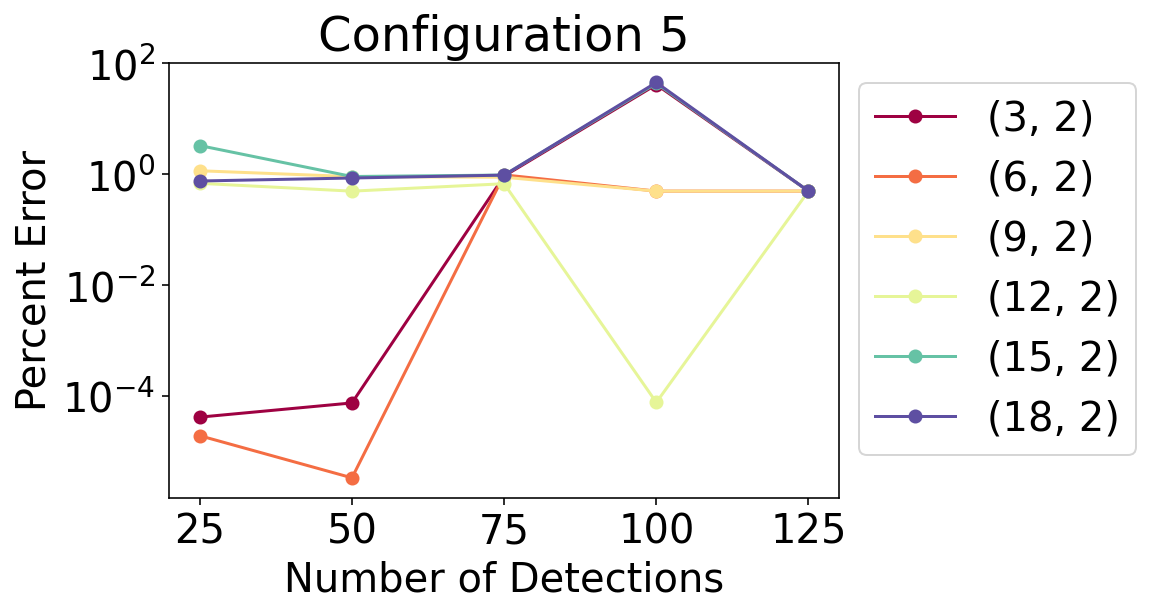

In [825]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.plot(nds, [pe_1[i], pe_2[i], pe_3[i], pe_4[i], pe_5[i]], 
            'o-', color=cmap(0.2*i), label=f'({3*i+3}, 2)')
    plt.legend(bbox_to_anchor=(1,1))
plt.axhline(0, color='k', ls='--')
plt.yscale('log')

plt.ylabel("Percent Error")
plt.xlabel("Number of Detections")
plt.title("Configuration 5")

Text(0.5, 1.0, 'Configuration 5')

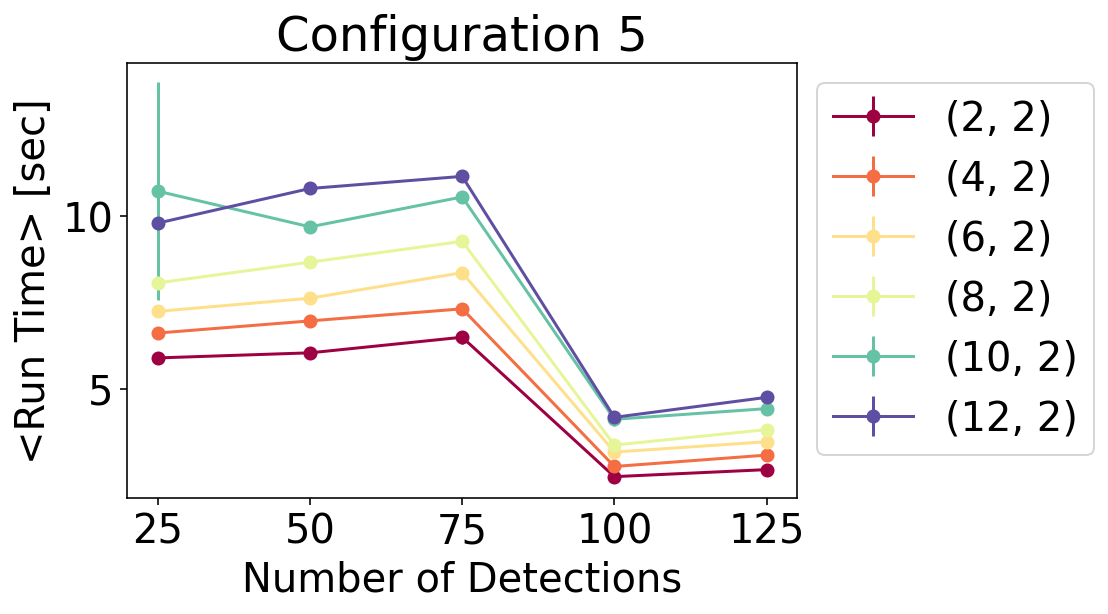

In [827]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.errorbar(nds, [rt1[i], rt2[i], rt3[i], rt4[i], rt5[i]],
                 yerr=[e_rt1[i], e_rt2[i], e_rt3[i], e_rt4[i], e_rt5[i]],
            fmt='o-', color=cmap(0.2*i), label=f'({2*i+2}, 2)')
    plt.legend(bbox_to_anchor=(1,1), fontsize=20)

plt.ylabel("<Run Time> [sec]")
plt.xlabel("Number of Detections")
plt.title("Configuration 5")